# Do interface design on the best docks

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders
dig97


### Make a function to do one sided PPI design
use `tutorial_design_v5.xml` as an example
added CYS/CYD restriction  
try `<Index name="" resnums="{}" />` instead of slices             

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init


@requires_init
def almost_intdes(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Wrap a pyrosetta compatible version of @bcov interface design v5 xml.
    Save scores to pose
    """
    import bz2
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    # TODO
    print("test")
    print(
        [
            base_residue_type.name3()
            for base_residue_type in pyrosetta.Pose()
            .conformation()
            .modifiable_residue_type_set_for_conf()
            .base_residue_types()
        ]
    )

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            packed_pose_in = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    else:
        raise RuntimeError("Need to supply an input")

    if "sasa_threshold" in kwargs.keys():
        sasa_threshold = kwargs["sasa_threshold"]
    else:
        sasa_threshold = 1350

    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" />
            <ScoreFunction name="sfxn_soft" weights="beta_nov16_soft" />
            <ScoreFunction name="sfxn_fa_atr" weights="empty" >
                <Reweight scoretype="fa_atr" weight="1" />
            </ScoreFunction>
            <ScoreFunction name="sfxn_relax" weights="beta_nov16" >
                <Reweight scoretype="arg_cation_pi" weight="3" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="5" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-0.5" />
            </ScoreFunction>
            <ScoreFunction name="sfxn_design" weights="beta_nov16" >
                <Reweight scoretype="res_type_constraint" weight="1.5" />
                <Reweight scoretype="aa_composition" weight="1.0" />
                <Reweight scoretype="arg_cation_pi" weight="3" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="5" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-0.5" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-1" />
            </ScoreFunction>
            <ScoreFunction name="vdw_sol" weights="empty" >
                <Reweight scoretype="fa_atr" weight="1.0" />
                <Reweight scoretype="fa_rep" weight="0.55" />
                <Reweight scoretype="fa_sol" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        <TASKOPERATIONS>
            <SelectBySASA name="PR_monomer_core_sel" mode="sc" state="monomer" probe_radius="2.2" core_asa="15" surface_asa="15" core="0" boundary="1" surface="1" verbose="0" />
        </TASKOPERATIONS>
        <RESIDUE_SELECTORS>
            <Chain name="chainA" chains="A"/>
            <Chain name="chainB" chains="B"/>
            <Neighborhood name="interface_chA" selector="chainB" distance="10.0" />
            <Neighborhood name="interface_chB" selector="chainA" distance="10.0" />
            <And name="AB_interface" selectors="interface_chA,interface_chB" />
            <Not name="Not_interface" selector="AB_interface" />
            <And name="actual_interface_chA" selectors="AB_interface,chainA" />
            <And name="actual_interface_chB" selectors="AB_interface,chainB" />
            <And name="chainB_not_interface" selectors="Not_interface,chainB" />
            <Not name="not_chB" selector="chainB" />

            <ResidueName name="pro_and_gly_positions" residue_name3="PRO,GLY,CYS,CYD" />
            <ResidueName name="apolar" residue_name3="ALA,CYS,PHE,ILE,LEU,MET,THR,PRO,VAL,TRP,TYR" />
            <Not name="polar" selector="apolar" />

            <InterfaceByVector name="interface_by_vector" cb_dist_cut="11" nearby_atom_cut="5.5" vector_angle_cut="75" vector_dist_cut="9" grp1_selector="actual_interface_chA" grp2_selector="actual_interface_chB"/>
            <Task name="all_cores" fixed="true" task_operations="PR_monomer_core_sel" packable="false" designable="false"/>
            <And name="for_hydrophobic" selectors="actual_interface_chA,interface_by_vector">
                <Not selector="all_cores" />
            </And>

            <ResiduePDBInfoHasLabel name="HOTSPOT_res" property="HOTSPOT" />
            <ResiduePDBInfoHasLabel name="DONE_res" property="DONE" />
            
            <Index name="res1" resnums="1" />
            <Index name="patchdock_res" resnums="{interface_hydrophobics}" />

            <Index name="pocket" resnums="{interface_hydrophobics}" />
            <And name="target_not_pocket" selectors="chainB">
                <Not selector="pocket" />
            </And>

            <Layer name="surface" select_core="false" select_boundary="false" select_surface="true" use_sidechain_neighbors="true"/>
            <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" use_sidechain_neighbors="true"/>
            <Layer name="core" select_core="true" select_boundary="false" select_surface="false" use_sidechain_neighbors="true"/>
            <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="E"/>
            <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
            <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="H"/>
            <And name="helix_cap" selectors="entire_loop">
                <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
            </And>
            <And name="helix_start" selectors="entire_helix">
                <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
            </And>
            <And name="helix" selectors="entire_helix">
                <Not selector="helix_start"/>
            </And>
            <And name="loop" selectors="entire_loop">
                <Not selector="helix_cap"/>
            </And>

        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <DesignRestrictions name="layer_design_F_boundary_M">
                <Action selector_logic="not_chB AND surface AND helix_start"  aas="DEHKPQR"/>
                <Action selector_logic="not_chB AND surface AND helix"        aas="EHKQR"/>
                <Action selector_logic="not_chB AND surface AND sheet"        aas="EHKNQRST"/>
                <Action selector_logic="not_chB AND surface AND loop"         aas="DEGHKNPQRST"/>
                <Action selector_logic="not_chB AND boundary AND helix_start" aas="ADEFHIKLMNPQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND helix"       aas="ADEFHIKLMNQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND sheet"       aas="DEFHIKLMNQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND loop"        aas="ADEFGHIKLNPQRSTVWY"/>
                <Action selector_logic="not_chB AND core AND helix_start"     aas="AFILMPVWY"/>
                <Action selector_logic="not_chB AND core AND helix"           aas="AFILMVWYDENQSTH"/>
                <Action selector_logic="not_chB AND core AND sheet"           aas="FILMVWYDENQSTH"/>
                <Action selector_logic="not_chB AND core AND loop"            aas="AFGILPVWYDENQSTH"/>
                <Action selector_logic="not_chB AND helix_cap"                aas="DNST"/>
            </DesignRestrictions>
        </TASKOPERATIONS>
        <MOVERS>
            <AddCompositionConstraintMover name="3trp" >
                <Comp entry="PENALTY_DEFINITION;TYPE TRP;ABSOLUTE 0;PENALTIES 0 3;DELTA_START 0;DELTA_END 1;BEFORE_FUNCTION CONSTANT;AFTER_FUNCTION LINEAR;END_PENALTY_DEFINITION;" />
            </AddCompositionConstraintMover>
            <AddCompositionConstraintMover name="2met" >
                <Comp entry="PENALTY_DEFINITION;TYPE MET;ABSOLUTE 0;PENALTIES 0 2;DELTA_START 0;DELTA_END 1;BEFORE_FUNCTION CONSTANT;AFTER_FUNCTION LINEAR;END_PENALTY_DEFINITION;" />
            </AddCompositionConstraintMover>
            <AddCompositionConstraintMover name="30_percent_polar" selector="for_hydrophobic">
                <Comp entry="PENALTY_DEFINITION;TYPE ASP GLU HIS LYS ASN GLN ARG SER THR TYR;FRACT_DELTA_START -0.01;FRACT_DELTA_END 0.0;PENALTIES 0.1 0 ;FRACTION 0.30;BEFORE_FUNCTION QUADRATIC;AFTER_FUNCTION CONSTANT;END_PENALTY_DEFINITION" />
            </AddCompositionConstraintMover>
        </MOVERS>
        <TASKOPERATIONS>
            <PruneBuriedUnsats name="prune_buried_unsats" allow_even_trades="false" atomic_depth_cutoff="3.5" minimum_hbond_energy="-0.5" />
            <ProteinProteinInterfaceUpweighter name="upweight_interface" interface_weight="3" />
            <ProteinInterfaceDesign name="pack_long" design_chain1="0" design_chain2="0" jump="1" interface_distance_cutoff="15"/>
            <IncludeCurrent name="current" />
            <LimitAromaChi2 name="limitchi2" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2aro="1" />

            <OperateOnResidueSubset name="restrict_target_not_interface" selector="chainB_not_interface">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_to_interface" selector="Not_interface">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_target2repacking" selector="chainB">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_hotspots2repacking" selector="HOTSPOT_res">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <DisallowIfNonnative name="disallow_GLY" resnum="0" disallow_aas="G" />
            <DisallowIfNonnative name="disallow_PRO" resnum="0" disallow_aas="P" />
            <OperateOnResidueSubset name="restrict_PRO_GLY" selector="pro_and_gly_positions">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>

            <SelectBySASA name="PR_monomer_core" mode="sc" state="monomer" probe_radius="2.2" core_asa="10" surface_asa="10" core="0" boundary="1" surface="1" verbose="0" />

        </TASKOPERATIONS>
        <RESIDUE_SELECTORS>
            <And name="sheetA" selectors="sheet,chainA" />
        </RESIDUE_SELECTORS>
        <MOVERS>

            <DeleteRegionMover name="delete_target_not_pocket" residue_selector="target_not_pocket" rechain="false" />

            <SwitchChainOrder name="chain1onlypre" chain_order="1" />
            <ScoreMover name="scorepose" scorefxn="sfxn" verbose="false" />
            <ParsedProtocol name="chain1only">
                <Add mover="chain1onlypre" />
                <Add mover="scorepose" />
            </ParsedProtocol>
            <TaskAwareMinMover name="min" scorefxn="sfxn" bb="0" chi="1" task_operations="pack_long" />

            <DeleteRegionMover name="delete_polar" residue_selector="polar" rechain="false" />

            <FastRelax name="relax_chain1" scorefxn="sfxn" repeats="1" batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone" task_operations="ex1_ex2,limitchi2" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="true" />
                </MoveMap>
            </FastRelax>

            <ParsedProtocol name="chain1only_relax">
                <Add mover="chain1onlypre" />
                <Add mover="relax_chain1" />
            </ParsedProtocol>

            <StructProfileMover name="genProfile" add_csts_to_pose="1" consider_topN_frags="100" eliminate_background="0" ignore_terminal_residue="1" only_loops="0" burialWt="0" RMSthreshold="0.6" residue_selector="chainA" />

            <ClearConstraintsMover name="clear_constraints" />

            <SavePoseMover name="save_output" restore_pose="0" reference_name="pose_output" />
            <SavePoseMover name="load_output" restore_pose="1" reference_name="pose_output" />

            <LabelPoseFromResidueSelectorMover name="remove_done" remove_property="DONE"  residue_selector="res1" />
            <LabelPoseFromResidueSelectorMover name="add_done" property="DONE" residue_selector="res1" />

        </MOVERS>
        <FILTERS>
            <Sasa name="interface_buried_sasa" confidence="0" />
            <Sasa name="gate_filter" threshold="{sasa_threshold}" confidence="1" />
            <Ddg name="ddg"  threshold="-10" jump="1" repeats="5" repack="1" relax_mover="min" confidence="0" scorefxn="sfxn" extreme_value_removal="1" />

            <ShapeComplementarity name="interface_sc" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>
            <ShapeComplementarity name="interface_sc_for_fr1" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>

            <ScoreType name="total_score_MBF" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
            <MoveBeforeFilter name="total_score_monomer" mover="chain1only" filter="total_score_MBF" confidence="0" />
            <ResidueCount name="res_count_MBF" max_residue_count="9999" confidence="0"/>
            <MoveBeforeFilter name="res_count_monomer" mover="chain1only" filter="res_count_MBF" confidence="0" />

            <CalculatorFilter name="score_per_res" equation="total_score_monomer / res" threshold="-3.5" confidence="0">
                <Var name="total_score_monomer" filter="total_score_monomer"/>
                <Var name="res" filter="res_count_monomer"/>
            </CalculatorFilter>

            <MoveBeforeFilter name="total_score_relax_monomer" mover="chain1only_relax" filter="total_score_MBF" confidence="0" />

            <CalculatorFilter name="score_per_res_relax" equation="total_score_relax_monomer / res" threshold="-3.5" confidence="0">
                <Var name="total_score_relax_monomer" filter="total_score_relax_monomer"/>
                <Var name="res" filter="res_count_monomer"/>
            </CalculatorFilter>

            <BuriedUnsatHbonds name="buns_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" max_hbond_energy="1.5" burial_cutoff_apo="0.2" />
            <BuriedUnsatHbonds name="sbuns5.0_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.0" atomic_depth_deeper_than="false" burial_cutoff_apo="0.2" atomic_depth_resolution="0.49" max_hbond_energy="1.5"/>

            <BuriedUnsatHbonds name="vbuns5.0_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.0" burial_cutoff="1000" burial_cutoff_apo="0.2" atomic_depth_apo_surface="5.5" atomic_depth_resolution="0.49" max_hbond_energy="1.5"/>

            <InterfaceHydrophobicResidueContacts name="hydrophobic_residue_contacts" target_selector="chainB" binder_selector="chainA" scorefxn="sfxn_soft" confidence="0"/> 
            <ContactMolecularSurface name="contact_molecular_surface" distance_weight="0.5" target_selector="chainA" binder_selector="chainB" confidence="0" />
            <ContactMolecularSurface name="contact_patch" distance_weight="0.5" target_selector="patchdock_res" binder_selector="chainA" confidence="0" />

            <Ddg name="ddg_hydrophobic_pre"  threshold="-10" jump="1" repeats="1" repack="0" confidence="0" scorefxn="vdw_sol" />
            <MoveBeforeFilter name="ddg_hydrophobic" mover="delete_polar" filter="ddg_hydrophobic_pre" confidence="0"/>

            <Ddg name="fa_atr_pocket_pre"  threshold="-15" jump="1" repeats="1" repack="0" confidence="0" scorefxn="sfxn_fa_atr" />
            <MoveBeforeFilter name="fa_atr_pocket" mover="delete_target_not_pocket" filter="fa_atr_pocket_pre" confidence="0"/>

            <SSPrediction name="pre_sspred_overall" cmd="/software/psipred4/runpsipred_single" use_probability="0" use_svm="0" threshold="0.85" confidence="0" />
            <MoveBeforeFilter name="sspred_overall" mover="chain1only" filter="pre_sspred_overall" confidence="0" />

            <SSPrediction name="pre_mismatch_probability" confidence="0" cmd="/software/psipred4/runpsipred_single" use_probability="1" mismatch_probability="1" use_svm="0" />
            <MoveBeforeFilter name="mismatch_probability" mover="chain1only" filter="pre_mismatch_probability" confidence="0" />

            <ScorePoseSegmentFromResidueSelectorFilter name="has_sheet" in_context="1" residue_selector="sheetA" scorefxn="sfxn" confidence="0" />
            <ScorePoseSegmentFromResidueSelectorFilter name="was_done" in_context="1" residue_selector="DONE_res" scorefxn="sfxn" confidence="0" />

            <SSShapeComplementarity name="ss_sc_pre" verbose="0" confidence="0" />
            <MoveBeforeFilter name="ss_sc" mover="chain1only" filter="ss_sc_pre" confidence="0"/>

            <Time name="timed"/>
            <TrueFilter name="my_true_filter" />
        </FILTERS>
        <MOVERS>
            <FastDesign name="FastDesign" scorefxn="sfxn_design" repeats="1" task_operations="current,limitchi2,ex1_ex2,restrict_to_interface,restrict_target2repacking,restrict_hotspots2repacking,disallow_GLY,disallow_PRO,PR_monomer_core,upweight_interface,restrict_PRO_GLY,prune_buried_unsats,layer_design_F_boundary_M" batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                        <Chain number="1" chi="true" bb="true" />
                        <Chain number="2" chi="true" bb="false" />
                        <Jump number="1" setting="true" />
                </MoveMap>
            </FastDesign>
            ################################ prevent repacking of rif? ##################################################
            <FastRelax name="FastRelax" scorefxn="sfxn_relax" repeats="1" batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone" task_operations="current,ex1_ex2,restrict_target_not_interface,limitchi2,prune_buried_unsats" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="true" />
                    <Chain number="2" chi="true" bb="false" />
                    <Jump number="1" setting="true" />
                </MoveMap>
            </FastRelax>
            <ParsedProtocol name="go_go_go" mode="sequence">
                <Add filter="gate_filter" />
                Add mover="genProfile" />
                <Add mover="3trp" />
                <Add mover="2met" />
                <Add mover="30_percent_polar" />
                <Add mover="FastDesign" />
                <Add mover="save_output" />
                <Add mover="FastDesign" />
                <Add mover="clear_constraints" />
                <Add mover="FastRelax" />
                <Add mover="add_done" />
                <Add mover="save_output" />
            </ParsedProtocol>

            <GenericMonteCarlo name="try_go_go_go" mover_name="go_go_go" filter_name="my_true_filter" trials="1" />

        </MOVERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add filter="timed" />
            <Add mover="remove_done" />
            <Add mover="save_output" />
            <Add mover="try_go_go_go" />
            <Add mover="load_output" />
            <Add filter_name="interface_buried_sasa" />   
            <Add filter_name="ddg" />                     
            <Add filter="ddg_hydrophobic" />              
            <Add filter_name="interface_sc" />            
            <Add filter_name="score_per_res" />          
            Add filter_name="score_per_res_relax" />    
            <Add filter="vbuns5.0_heavy_ball_1.1D" />    
            <Add filter="sbuns5.0_heavy_ball_1.1D" />    
            <Add filter="buns_heavy_ball_1.1D" />    
            <Add filter="hydrophobic_residue_contacts" />
            <Add filter="fa_atr_pocket" />               
            Add filter="mismatch_probability" />        
            Add filter="sspred_overall" />              
            <Add filter="contact_molecular_surface" />
            <Add filter="contact_patch" />   
            <Add filter="ss_sc" />   
            <Add filter="has_sheet" />
            <Add filter="was_done" />
            <Add filter="timed" />
        </PROTOCOLS>
        <OUTPUT />
    </ROSETTASCRIPTS>
    """.format(
        interface_hydrophobics=scores["interface_hydrophobics"],
        sasa_threshold=sasa_threshold,
    )
    intdes = SingleoutputRosettaScriptsTask(xml)
    designed_ppose = intdes(packed_pose_in.pose.clone())
    new_scores = dict(designed_ppose.pose.scores)
    scores.update(new_scores)
    designed_pose = io.to_pose(designed_ppose)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(designed_pose, key, str(value))
    final_ppose = io.to_packed(designed_pose)
    return final_ppose

### We're going to do a huge run here, more than it makes sense to use dask for
Will submit everything to `backfill`
Make `SLURM` array tasks

In [10]:
import os, stat, subprocess


def create_tasks(selected):
    with open(selected, "r") as f:
        for file in f:
            for sasa in 0, 1350:
                tasks = {}
                path = file.rstrip()
                tasks["-s"] = path
                tasks["-sasa_threshold"] = sasa
                yield tasks


def file_len(file):
    """https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python"""
    with open(file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


targets = glob(os.path.join(os.getcwd(), "00_thread_targets/*.list"))
target_scale = {target: int(50000 / file_len(target)) for target in targets}
almost_intdes = os.path.join(os.getcwd(), "almost_intdes.py")

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

for target, scale in target_scale.items():
    basename_noext = target.split("/")[-1].replace(".list", "", 1)
    tasklist = f"01_intdes_tasks_{basename_noext}.cmds"
    run_sh = """#!/usr/bin/env bash \n#SBATCH -J almost_intdes \n#SBATCH -e /mnt/home/pleung/logs/slurm_logs/almost_intdes-%J.err \n#SBATCH -o /mnt/home/pleung/logs/slurm_logs/almost_intdes-%J.out \n#SBATCH -p {queue} \n#SBATCH --mem=4G \n\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
        queue="backfill", jid=jid, sid=sid, tasklist=tasklist, c="{CMD}"
    )
    shell = f"01_intdes_run_{basename_noext}.sh"
    with open(shell, "w+") as f:
        print(run_sh, file=f)
    st = os.stat(shell)
    os.chmod(shell, st.st_mode | stat.S_IEXEC)
    with open(f"01_intdes_tasks_{basename_noext}.cmds", "w+") as f:
        for nstruct in range(0, scale):
            outpath = os.path.join(os.getcwd(), f"01_intdes_runs_{basename_noext}")
            full_outpath = os.path.join(os.getcwd(), outpath, f"{nstruct}")
            for tasks in create_tasks(target):
                args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
                cmd = f"mkdir -p {full_outpath}; cd {full_outpath}; {almost_intdes} {args_}"
                print(cmd, file=f)

# Let's go
print("Run the following commands")
for target in targets:
    basename_noext = target.split("/")[-1].replace(".list", "", 1)
    print(
        f"sbatch -a 1-$(cat 01_intdes_tasks_{basename_noext}.cmds | wc -l) 01_intdes_run_{basename_noext}.sh"
    )

Run the following commands
sbatch -a 1-$(cat 01_intdes_tasks_pth.cmds | wc -l) 01_intdes_run_pth.sh
sbatch -a 1-$(cat 01_intdes_tasks_neuropeptideY.cmds | wc -l) 01_intdes_run_neuropeptideY.sh
sbatch -a 1-$(cat 01_intdes_tasks_glp.cmds | wc -l) 01_intdes_run_glp.sh
sbatch -a 1-$(cat 01_intdes_tasks_glucagon.cmds | wc -l) 01_intdes_run_glucagon.sh
sbatch -a 1-$(cat 01_intdes_tasks_apoe.cmds | wc -l) 01_intdes_run_apoe.sh
sbatch -a 1-$(cat 01_intdes_tasks_gip.cmds | wc -l) 01_intdes_run_gip.sh
sbatch -a 1-$(cat 01_intdes_tasks_covstem.cmds | wc -l) 01_intdes_run_covstem.sh


### Now need to retrieve the JSONs containing scores for the interface design runs

In [5]:
%%time
import json

output_paths = glob(os.path.join(os.getcwd(), "01_intdes_runs_*/*/*.json"))

scores = {}

for test in tqdm(output_paths):
    pdb = test.replace("json", "pdb.bz2")
    key = f"{pdb}"
    with open(test, "r") as f:
        values = json.load(f)
    scores[key] = values

100%|██████████| 35879/35879 [00:35<00:00, 998.86it/s] 

CPU times: user 6.69 s, sys: 3.77 s, total: 10.5 s
Wall time: 36.6 s


### Write them back to disk as a single scorefile


In [6]:
%%time
scores_df = pd.DataFrame(scores)
scores_df = scores_df.T
output_path = os.path.join(os.getcwd(), "01_filter")
output_file = os.path.join(output_path, "scores.json")
os.makedirs(output_path, exist_ok=True)
scores_df.to_json(output_file)

CPU times: user 6.72 s, sys: 1.22 s, total: 7.93 s
Wall time: 8.36 s


In [2]:
output_path = os.path.join(os.getcwd(), "01_filter")
scores = os.path.join(output_path, "scores.json")
scores_df = pd.read_json(scores)
scores_df.head()

,9mer,abego_str,bb_clash,buns_heavy_ball_1.1D,chB_length,chB_start,closure_type,cmsa_AB,cmsa_AC,cmsa_BC,...,target_name,target_seq,threaded_seq,timed,total_length,total_score,vbuns5.0_heavy_ball_1.1D,was_done,cart_bonded,coordinate_constraint
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/0/c3b5466017c1e642ba1238f752d6fe96f3c6d4f329ab9f82.pdb.bz2,2.687330,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,75.377159,0,24,219,loop_match,578.997192,230.397964,498.677643,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,TFTSDVSSYLEGQAAKEFIAWLVK,1038,242,-838.786481,0,-4.287387,NaN,NaN
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/0/13433473b145a7d2609844e59cb73266f2548a12c1441c76.pdb.bz2,3.300876,XAAAAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAA...,7444.855957,1,22,316,strict_remodel,610.022705,280.845032,247.083069,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,TSDVSSYLEGQAAKEFIAWLVK,1024,337,-1291.137602,0,-0.201243,NaN,NaN
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/0/c1044aa9643f666d20276fb612511d1b117b509ea73dbd3b.pdb.bz2,2.789464,XAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAABABAAAAAAAA...,42.635773,1,15,150,strict_remodel,288.266022,161.136383,306.577484,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,VSSYLEGQAAKEFIA,589,164,-521.585621,0,-0.956512,NaN,NaN
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/0/c497b6b047ddc309ac114f8dfca7997df6c59e50c6401ee2.pdb.bz2,3.180000,XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAABAB...,3571.504883,1,19,181,loop_match,427.363861,297.413147,365.562500,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,SSYLEGQAAKEFIAWLVKG,773,199,-622.293696,3,-1.611636,NaN,NaN
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/0/eedbebde3526939cd72c91f101c242992db412d4f7e08145.pdb.bz2,2.280598,XAAAAAAAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAA...,90.142479,2,24,317,strict_remodel,399.160553,273.109497,469.339386,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,GTFTSDVSSYLEGQAAKEFIAWLV,1150,340,-1222.690390,1,-0.762726,NaN,NaN


In [3]:
def row2state(row):
    state = (
        row["parent"]
        + "_p_"
        + str(int(row["pivot_helix"]))
        + "_s_"
        + str(int(row["shift"]))
        + "_d_"
        + str(int(row["docked_helix"]))
    )
    return state


scores_df["state"] = scores_df.apply(row2state, axis=1)

/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/seaborn/dist

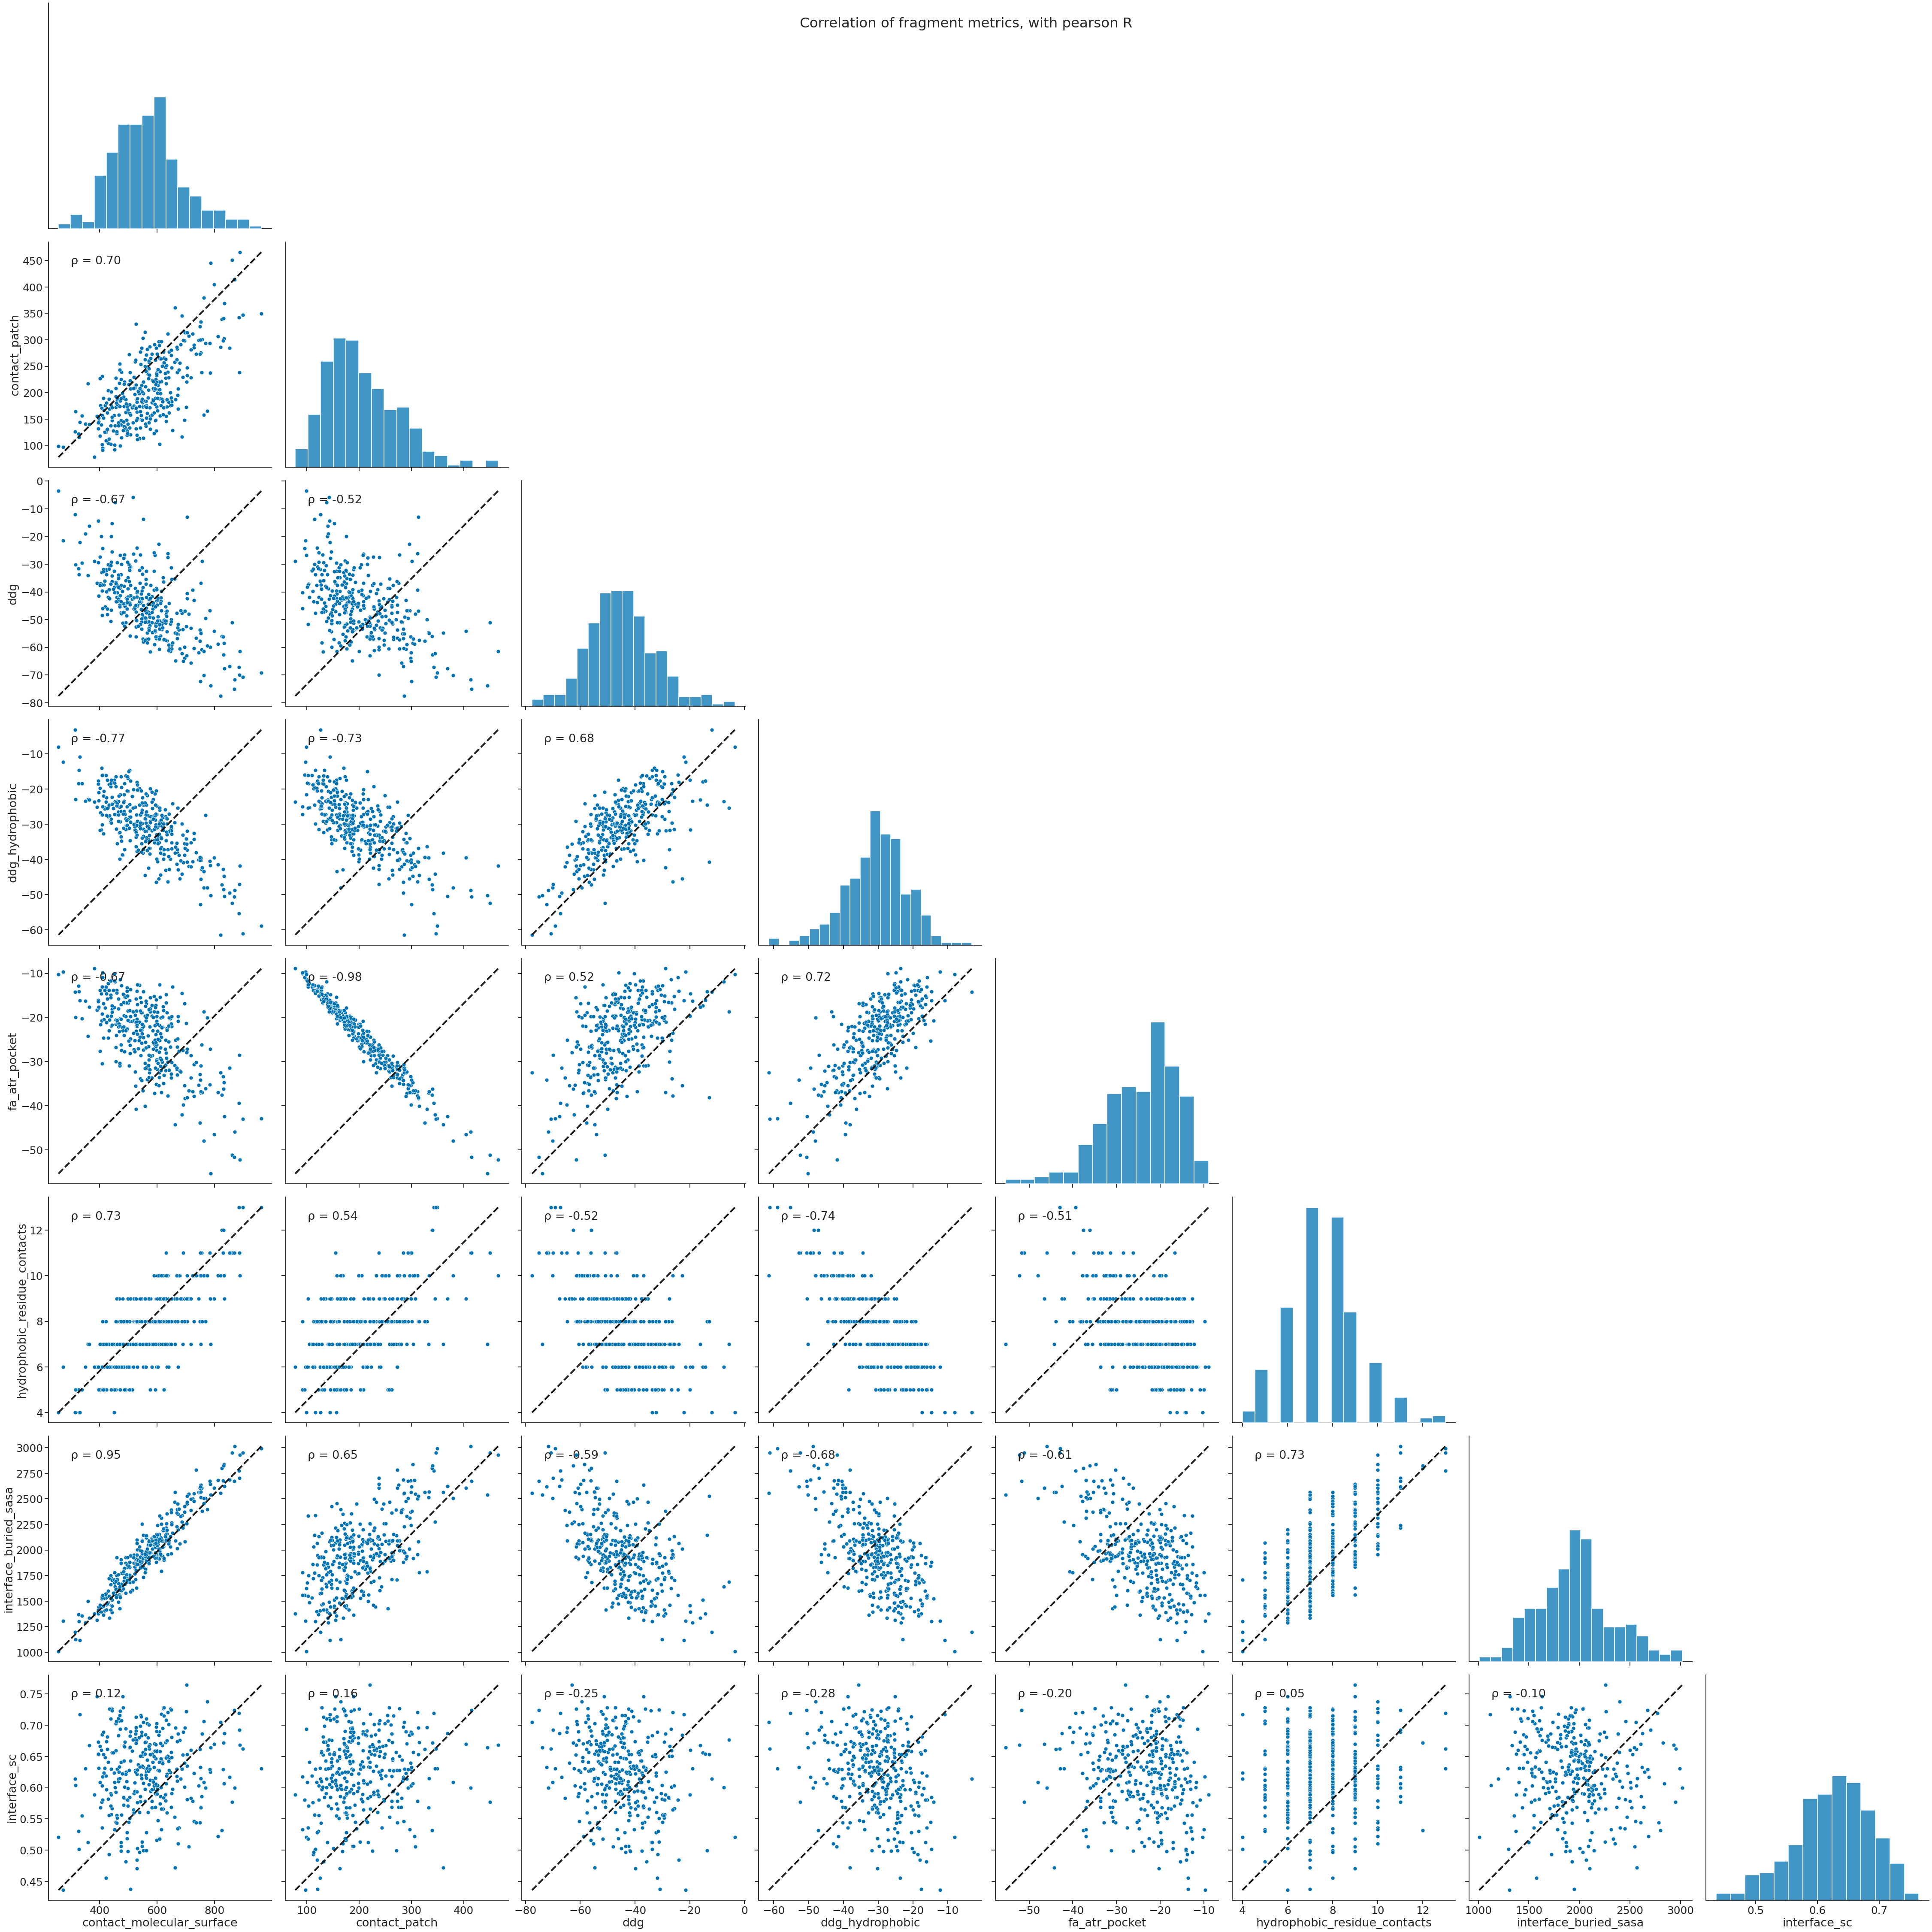

In [4]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)


def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy

    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)


def plot_unity(xdata, ydata, **kwargs):
    """https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot"""
    xmin, ymin = (xdata.min(), ydata.min())
    xmax, ymax = (xdata.max(), ydata.max())
    xpoints = np.linspace(xmin, xmax, 100)
    ypoints = np.linspace(ymin, ymax, 100)
    plt.gca().plot(
        xpoints, ypoints, color="k", marker=None, linestyle="--", linewidth=4.0
    )


subset = scores_df[scores_df["ddg"] < 0]
subset = subset[subset["ddg_hydrophobic"] < 0]

subset = subset[
    [
        "contact_molecular_surface",
        "contact_patch",
        "ddg",
        "ddg_hydrophobic",
        "dslf_fa13",
        "fa_atr_pocket",
        "hydrophobic_residue_contacts",
        "interface_buried_sasa",
        "interface_sc",
        "score_per_res",
        "ss_sc",
        "vbuns5.0_heavy_ball_1.1D",
        "parent",
        "state",
        "target_name",
    ]
]

pack_subset = subset[
    [
        "contact_molecular_surface",
        "contact_patch",
        "ddg",
        "ddg_hydrophobic",
        "fa_atr_pocket",
        "hydrophobic_residue_contacts",
        "interface_buried_sasa",
        "interface_sc",
        "parent",
        "state",
        "target_name",
    ]
]

ax = sns.pairplot(
    data=pack_subset.sample(frac=0.01), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of interface metrics, split by parent")
sns.despine()
plt.savefig("figs/01_correlations_int_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=pack_subset.sample(frac=0.01), corner=True, height=8)
ax.map_lower(rho)
ax.map_offdiag(plot_unity)
plt.suptitle("Correlation of fragment metrics, with pearson R")
sns.despine()
plt.savefig("figs/01_correlations_int_pearson.png")

In [6]:
d_high = scores_df[scores_df["ddg"] < -40]
# d_high = d_high[d_high["sap_Y"] < 25]
d_high = d_high[d_high["vbuns5.0_heavy_ball_1.1D"] < 1]
d_high = d_high[d_high["score_per_res"] < -3]
# d_high = d_high[d_high["d_hinge_complex_formation"] > 10]
# d_high = d_high[d_high["wnm_all_X"] < 0.8]
# d_high = d_high[d_high["wnm_all_Y"] < 0.8]

print(len(set(d_high.state.values)))
print(len(d_high))
print(len(set(d_high.parent.values)))
set(scores_df.parent.values) - set(d_high.parent.values)

259
10115
56


{'THR4'}

In [11]:
short = d_high[d_high["chB_start"] < 167]
print(len(short))
print(set(short.parent.values))

1308
{'hDHR14_5CWH', 'hDHR14_5H7C', 'DHR07_nocys', 'hDHR49_5CWJ', 'DHR39', 'DHR21'}


### Setup dask, set command line options, make tasks and submit to client again to test design
I want to see if there's sequence convergence at nstruct 1000 for a random input

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)


logging.basicConfig(level=logging.INFO)

options = {
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    #     "-extra_res_fa": "",
    #     "-extra_res_cen": "",
}
tasks = {"options": "-corrections::beta_nov16 true"}
tasks["extra_options"] = options
tasks[
    "-s"
] = "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/00_thread_targets/decoys/0000/2021.07.12.10.35.38.485279_00431f82398d4a56b6d2e29532614d17.pdb.bz2"

output_path = os.path.join(os.getcwd(), "01_test_500")


# TODO
flags = """
-out:level 300
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5
-run:constant_seed 1
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
# TODO
print([base_residue_type.name3() for base_residue_type in pyrosetta.Pose().conformation().modifiable_residue_type_set_for_conf().base_residue_types()])

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="long",
        walltime="2:59:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "3h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-510 workers,
        cluster.adapt(
            minimum=1,
            maximum=510,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=tasks,
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
                nstruct=10,
#                 sha1=None,
                dry_run=True,
            ).distribute(protocols=[almost_intdes])

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-out:level 300 -corrections::beta_nov16 true -holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc -indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5 -run:constant_seed 1', 'extra_options': '-out:levels all:warning', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.27+release.7ce64884a77d606b7b667c363527acc846541030 2021-07-09T18:10:05] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] Att

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig57
['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', ' DA', ' DT', ' DC', ' DG', 'MCY', 'TRD', 'TRC', 'TRG', 'TUR', 'TFT', '  A', '  C', '  G', '  U', ' IC', '  I', '1AP', '1MA', '2MA', '2MG', '2MU', '4OC', '5MC', '5MU', 'BRU', '5BU', '7MG', 'G7M', '7DA', 'M2G', 'MA6', 'PSU', 'UR3', '6MZ', '1MG', '4SU', '3TD', 'H2U', 'MIA', 'A2M', 'OMC', 'OMG', 'OMU', '5JO', 'A44', 'C43', 'C5L', 'G48', 'U36', 'FMA', 'FMC', 'FMG', 'FMU', 'SRA', 'SRC', 'SRG', 'SRU', 'SSA', 'SSC', 'SSG', 'SSU', 'NPU', '5FU', '5IU', '2AP', 'PUR', '6MG', '5FC', '8OG', 'OMI', 'CFM', 'PPU', '1PU', '2ST', '2SU', '31U', '52U', 'I6A', 'M1I', 'MPU', 'AET', 'T6A', 'S2C', '3MC', 'A4C', 'K2C', 'F5C', '52C', 'FA7', 'IHA', 'RIA', '  Q', 'YYG', 'O2W', 'NMT', 'NST', 'C5T', 'CMT', 'MOT', 'MST', 'CNT', 'CNS', 'CNM', 'APU', 'OAU', 'MOU', 'MHU', 'M3G', 'M26'

WorkerError: 
Worker thread killed due to an error or segmentation fault encountered in the user-provided PyRosetta protocol '
Worker thread killed due to an error or segmentation fault encountered in the user-provided PyRosetta protocol 'almost_intdes'. '. 

In [4]:
cluster = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', ' DA', ' DT', ' DC', ' DG', 'MCY', 'TRD', 'TRC', 'TRG', 'TUR', 'TFT', '  A', '  C', '  G', '  U', ' IC', '  I', '1AP', '1MA', '2MA', '2MG', '2MU', '4OC', '5MC', '5MU', 'BRU', '5BU', '7MG', 'G7M', '7DA', 'M2G', 'MA6', 'PSU', 'UR3', '6MZ', '1MG', '4SU', '3TD', 'H2U', 'MIA', 'A2M', 'OMC', 'OMG', 'OMU', '5JO', 'A44', 'C43', 'C5L', 'G48', 'U36', 'FMA', 'FMC', 'FMG', 'FMU', 'SRA', 'SRC', 'SRG', 'SRU', 'SSA', 'SSC', 'SSG', 'SSU', 'NPU', '5FU', '5IU', '2AP', 'PUR', '6MG', '5FC', '8OG', 'OMI', 'CFM', 'PPU', '1PU', '2ST', '2SU', '31U', '52U', 'I6A', 'M1I', 'MPU', 'AET', 'T6A', 'S2C', '3MC', 'A4C', 'K2C', 'F5C', '52C', 'FA7', 'IHA', 'RIA', '  Q', 'YYG', 'O2W', 'NMT', 'NST', 'C5T', 'CMT', 'MOT', 'MST', 'CNT', 'CNS', 'CNM', 'APU', 'OAU', 'MOU', 'MHU', 'M3G', 'M26', '2FU', 'O3A', 'O3I', 'O3L', 'O3F', 'O3N', 'O3P', 'O3T', 'O3Q', 'O3V', 'O3W', 'O3Y', ' CA', ' CD', ' CO', ' CU', ' FE', 'FE2', '  K', ' MG', ' MN', ' NA', ' ZN', 'R1A', 'CED', 'C2X', 'C3X', 'C4X', 'NTA', 'XXX', 'SCK', 'XXX', 'YYY', 'XXX', 'XXX', '08A', '08B', 'WAT', 'TP5', 'HOH', 'HOH', 'HOH', 'HOH', 'BMT', 'LMA', 'AIB', 'MPH', 'V01', 'V02', 'V03', 'V04', 'ABA', 'APA', 'HLU', 'YPN', 'HPR', 'HTY', 'MPA', 'MTP', 'NLU', 'NVL', ' BZ', 'SAL', 'BCS', '0TD', 'A04', 'A06', 'A07', 'A12', 'A20', 'A24', 'BMA', 'A30', 'A31', 'A32', 'A33', 'A34', 'A43', 'IGL', 'A45', 'A48', 'DPP', 'DAB', 'A68', 'A69', 'C95', 'A78', 'A80', 'A82', 'A83', 'A84', 'A91', 'A92', 'dhI', 'A94', 'A98', 'B02', 'B06', 'B12', 'B19', 'C89', 'C90', 'B21', 'B27', 'B28', 'B30', 'BIF', 'B31', 'C80', 'C81', 'B35', 'B36', 'B38', 'C83', 'C84', 'C85', 'B40', 'C86', 'C87', 'C88', 'B44', 'B47', 'B48', 'B49', 'B50', 'B54', 'B56', 'B57', 'B58', 'B59', 'B60', 'B61', 'B62', 'B63', 'B67', 'B74', 'B95', 'B96', 'B97', 'C00', 'C01', 'C03', 'C04', 'C05', 'C12', 'C15', 'C16', 'C20', 'C91', 'C92', 'C93', 'C26', 'C27', 'C30', 'C36', 'ORN', '4J5', 'C41', 'C42', 'BB8', 'C53', 'C54', 'C55', 'C60', 'C94', 'C61', 'TES', 'S56', '001', '003', '004', '005', '006', '007', '009', '010', '020', '101', '102', '103', '104', '111', '114', '115', '116', '117', '118', '120', '127', '128', '129', '130', '202', '203', '204', '205', '206', '208', '209', '210', '211', '303', '305', '306', '307', '313', '314', '332', '333', '401', '402', '406', '410', '411', '412', '601', '621', '623', '631', '633', 'B3A', 'B3C', 'B3D', 'B3E', 'B3F', 'B3G', 'B3H', 'B3I', 'B3K', 'B3L', 'B3M', 'B3N', 'B3O', 'B3P', 'B3Q', 'B3R', 'B3S', 'B3T', 'B3V', 'B3W', 'B3X', 'B3Y', 'CAH', 'CAC', 'TAC', 'MEM', 'EMB', 'DMA', 'ACE', 'NME', 'BZO', 'BZA', ' CZ', 'APN', 'CPN', 'GPN', 'TPN', 'UPN', 'Fl ', 'Fl ', 'ATP', 'UDP', 'SAM', 'SAH', 'OAA', 'OAC', 'OAD', 'OAE', 'OAF', 'OAG', 'OAH', 'OAI', 'OAK', 'OAL', 'OAM', 'OAN', 'OAQ', 'OAR', 'OAS', 'OAT', 'OAV', 'OAW', 'OAY', 'OA1', 'OA2', 'OA3', 'OA4', 'OA5', 'OA6', 'SAA', 'SAC', 'SAD', 'SAE', 'SAF', 'SAG', 'SAI', 'SAK', 'SAL', 'SAN', 'SAQ', 'SAR', 'SAS', 'SAT', 'SAV', 'SAW', 'SAY', 'SA1', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'TAA', 'TAC', 'TAD', 'TAE', 'TAF', 'TAG', 'TAH', 'TAI', 'TAK', 'TAL', 'TAM', 'TAN', 'TAQ', 'TAR', 'TAS', 'TAT', 'TAV', 'TAW', 'TAY', 'TA1', 'TA2', 'TA3', 'TA4', 'TA5', 'TA6', 'UAA', 'UAC', 'UAD', 'UAE', 'UAF', 'UAG', 'UAH', 'UAI', 'UAK', 'UAL', 'UAM', 'UAN', 'UAQ', 'UAR', 'UAS', 'UAT', 'UAV', 'UAW', 'UAY', 'UA1', 'UA2', 'UA3', 'UA4', 'UA5', 'UA6', 'MAA', 'MAC', 'MAD', 'MAE', 'MAF', 'MAG', 'MAH', 'MAI', 'MAK', 'MAL', 'MAM', 'MAQ', 'MAR', 'MAS', 'MAT', 'MAV', 'MAW', 'MAY', 'MA1', 'MA2', 'MA3', 'MA4', 'MA5', 'MA6', 'KAA', 'KAC', 'KAD', 'KAE', 'KAF', 'KAG', 'KAH', 'KAI', 'KAK', 'KAL', 'KAM', 'KAN', 'KAQ', 'KAR', 'KAS', 'KAT', 'KAV', 'KAW', 'KAY', 'KA1', 'KA2', 'KA3', 'KA4', 'KA5', 'KA6', 'LAA', 'LAC', 'LAD', 'LAE', 'LAF', 'LAG', 'LAH', 'LAI', 'LAK', 'LAL', 'LAM', 'LAN', 'LAQ', 'LAR', 'LAS', 'LAT', 'LAV', 'LAW', 'LAY', 'LA1', 'LA2', 'LA3', 'LA4', 'LA5', 'LA6', 'KLA', 'KLC', 'KLD', 'KLE', 'KLF', 'KLG', 'KLH', 'KLI', 'KLK', 'KLL', 'KLM', 'KLN', 'KLQ', 'KLR', 'KLS', 'KLT', 'KLV', 'KLW', 'KLY', 'KL1', 'KL2', 'KL3', 'KL4', 'KL5', 'KL6', 'PAA', 'PAC', 'PAD', 'PAE', 'PAF', 'PAG', 'PAH', 'PAI', 'PAK', 'PAL', 'PAM', 'PAN', 'PAQ', 'PAS', 'PAT', 'PAV', 'PAW', 'PAY', 'PA1', 'PA2', 'PA3', 'PA4', 'PA5', 'PA6', 'QAA', 'QAC', 'QAD', 'QAE', 'QAF', 'QAG', 'QAH', 'QAI', 'QAK', 'QAL', 'QAM', 'QAN', 'QAQ', 'QAR', 'QAS', 'QAT', 'QAV', 'QAW', 'QAY', 'QA1', 'QA2', 'QA3', 'QA4', 'QA5', 'QA6', 'RAA', 'RAC', 'RAD', 'RAE', 'RAF', 'RAG', 'RAH', 'RAI', 'RAK', 'RAL', 'RAM', 'RAN', 'RAQ', 'RAR', 'RAS', 'RAT', 'RAV', 'RAW', 'RAY', 'RA1', 'RA2', 'RA3', 'RA4', 'RA5', 'RA6', 'QRA', 'QRC', 'QRD', 'QRE', 'QRF', 'QRG', 'QRH', 'QRI', 'QRK', 'QRL', 'QRM', 'QRN', 'QRQ', 'QRR', 'QRS', 'QRT', 'QRV', 'QRW', 'QRY', 'QR1', 'QR2', 'QR3', 'QR4', 'QR5', 'QR6', 'HYP', '0AZ', 'DAL', 'DAR', 'DAN', 'DAS', 'DCS', 'DCS', 'DGN', 'DGU', 'DHI', 'DHI', 'DIL', 'DLE', 'DLY', 'DME', 'DPH', 'DPR', 'DSE', 'DTH', 'DTR', 'DTY', 'DVA', 'O3A', 'O3I', 'O3L', 'O3F', 'O3N', 'O3P', 'O3T', 'O3Q', 'O3V', 'O3W', 'O3Y', 'R1A', 'CED', 'C2X', 'C3X', 'C4X', 'NTA', 'XXX', '08A', '08B', 'BMT', 'LMA', 'MPH', 'V01', 'V02', 'V03', 'V04', 'ABA', 'APA', 'HLU', 'YPN', 'HPR', 'HTY', 'MPA', 'MTP', 'NLU', 'NVL', ' BZ', 'BCS', '0TD', 'A04', 'A06', 'A07', 'A12', 'A20', 'A24', 'BMA', 'A30', 'A31', 'A32', 'A33', 'A34', 'A43', 'IGL', 'A45', 'A48', 'DPP', 'DAB', 'A68', 'A69', 'C95', 'A78', 'A80', 'A82', 'A83', 'A84', 'A91', 'A92', 'dhI', 'A94', 'B12', 'B19', 'C89', 'C90', 'B21', 'B27', 'B28', 'B30', 'BIF', 'B31', 'C80', 'C81', 'B35', 'B36', 'B38', 'C83', 'C84', 'C85', 'B40', 'C86', 'C87', 'C88', 'B44', 'B47', 'B48', 'B49', 'B50', 'B54', 'B56', 'B57', 'B58', 'B59', 'B60', 'B61', 'B62', 'B63', 'B67', 'B74', 'B95', 'B96', 'B97', 'C00', 'C01', 'C03', 'C04', 'C05', 'C12', 'C20', 'C91', 'C92', 'C93', 'C26', 'C27', 'C30', 'C36', 'ORN', '4J5', 'C41', 'C42', 'BB8', 'C53', 'C54', 'C55', 'C60', 'C94', 'C61', 'TES', 'S56', 'B3A', 'B3C', 'B3D', 'B3E', 'B3F', 'B3H', 'B3I', 'B3K', 'B3L', 'B3M', 'B3N', 'B3O', 'B3P', 'B3Q', 'B3R', 'B3S', 'B3T', 'B3V', 'B3W', 'B3X', 'B3Y', 'CAH', 'CAC', 'TAC', 'DHY', 'D0A', '602', '622', '624', '632', '634', 'MCY', ' 0A', ' 0C', ' 0G', ' 0U', ' IC', '  I', '1AP', '1MA', '2MA', '2MG', '2MU', '4OC', '5MC', '5MU', 'BRU', '5BU', '7MG', 'G7M', '7DA', 'M2G', 'MA6', 'PSU', 'UR3', '6MZ', '1MG', '4SU', '3TD', 'H2U', 'MIA', 'A2M', 'OMC', 'OMG', 'OMU', '5JO', 'A44', 'C43', 'C5L', 'G48', 'U36', 'FMA', 'FMC', 'FMG', 'FMU', 'SRA', 'SRC', 'SRG', 'SRU', 'SSA', 'SSC', 'SSG', 'SSU', 'NPU', '5FU', '5IU', '2AP', 'PUR', '6MG', '5FC', '8OG', 'OMI', 'CFM', 'PPU', '1PU', '2ST', '2SU', '31U', '52U', 'I6A', 'M1I', 'MPU', 'AET', 'T6A', 'S2C', '3MC', 'A4C', 'K2C', 'F5C', '52C', 'FA7', 'IHA', 'RIA', '  Q', 'YYG', 'O2W', 'NMT', 'NST', 'C5T', 'CMT', 'MOT', 'MST', 'CNT', 'CNS', 'CNM', 'APU', 'OAU', 'MOU', 'MHU', 'M3G', 'M26', '2FU']
client = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', ' DA', ' DT', ' DC', ' DG', 'MCY', 'TRD', 'TRC', 'TRG', 'TUR', 'TFT', '  A', '  C', '  G', '  U', ' IC', '  I', '1AP', '1MA', '2MA', '2MG', '2MU', '4OC', '5MC', '5MU', 'BRU', '5BU', '7MG', 'G7M', '7DA', 'M2G', 'MA6', 'PSU', 'UR3', '6MZ', '1MG', '4SU', '3TD', 'H2U', 'MIA', 'A2M', 'OMC', 'OMG', 'OMU', '5JO', 'A44', 'C43', 'C5L', 'G48', 'U36', 'FMA', 'FMC', 'FMG', 'FMU', 'SRA', 'SRC', 'SRG', 'SRU', 'SSA', 'SSC', 'SSG', 'SSU', 'NPU', '5FU', '5IU', '2AP', 'PUR', '6MG', '5FC', '8OG', 'OMI', 'CFM', 'PPU', '1PU', '2ST', '2SU', '31U', '52U', 'I6A', 'M1I', 'MPU', 'AET', 'T6A', 'S2C', '3MC', 'A4C', 'K2C', 'F5C', '52C', 'FA7', 'IHA', 'RIA', '  Q', 'YYG', 'O2W', 'NMT', 'NST', 'C5T', 'CMT', 'MOT', 'MST', 'CNT', 'CNS', 'CNM', 'APU', 'OAU', 'MOU', 'MHU', 'M3G', 'M26', '2FU', 'O3A', 'O3I', 'O3L', 'O3F', 'O3N', 'O3P', 'O3T', 'O3Q', 'O3V', 'O3W', 'O3Y', ' CA', ' CD', ' CO', ' CU', ' FE', 'FE2', '  K', ' MG', ' MN', ' NA', ' ZN', 'R1A', 'CED', 'C2X', 'C3X', 'C4X', 'NTA', 'XXX', 'SCK', 'XXX', 'YYY', 'XXX', 'XXX', '08A', '08B', 'WAT', 'TP5', 'HOH', 'HOH', 'HOH', 'HOH', 'BMT', 'LMA', 'AIB', 'MPH', 'V01', 'V02', 'V03', 'V04', 'ABA', 'APA', 'HLU', 'YPN', 'HPR', 'HTY', 'MPA', 'MTP', 'NLU', 'NVL', ' BZ', 'SAL', 'BCS', '0TD', 'A04', 'A06', 'A07', 'A12', 'A20', 'A24', 'BMA', 'A30', 'A31', 'A32', 'A33', 'A34', 'A43', 'IGL', 'A45', 'A48', 'DPP', 'DAB', 'A68', 'A69', 'C95', 'A78', 'A80', 'A82', 'A83', 'A84', 'A91', 'A92', 'dhI', 'A94', 'A98', 'B02', 'B06', 'B12', 'B19', 'C89', 'C90', 'B21', 'B27', 'B28', 'B30', 'BIF', 'B31', 'C80', 'C81', 'B35', 'B36', 'B38', 'C83', 'C84', 'C85', 'B40', 'C86', 'C87', 'C88', 'B44', 'B47', 'B48', 'B49', 'B50', 'B54', 'B56', 'B57', 'B58', 'B59', 'B60', 'B61', 'B62', 'B63', 'B67', 'B74', 'B95', 'B96', 'B97', 'C00', 'C01', 'C03', 'C04', 'C05', 'C12', 'C15', 'C16', 'C20', 'C91', 'C92', 'C93', 'C26', 'C27', 'C30', 'C36', 'ORN', '4J5', 'C41', 'C42', 'BB8', 'C53', 'C54', 'C55', 'C60', 'C94', 'C61', 'TES', 'S56', '001', '003', '004', '005', '006', '007', '009', '010', '020', '101', '102', '103', '104', '111', '114', '115', '116', '117', '118', '120', '127', '128', '129', '130', '202', '203', '204', '205', '206', '208', '209', '210', '211', '303', '305', '306', '307', '313', '314', '332', '333', '401', '402', '406', '410', '411', '412', '601', '621', '623', '631', '633', 'B3A', 'B3C', 'B3D', 'B3E', 'B3F', 'B3G', 'B3H', 'B3I', 'B3K', 'B3L', 'B3M', 'B3N', 'B3O', 'B3P', 'B3Q', 'B3R', 'B3S', 'B3T', 'B3V', 'B3W', 'B3X', 'B3Y', 'CAH', 'CAC', 'TAC', 'MEM', 'EMB', 'DMA', 'ACE', 'NME', 'BZO', 'BZA', ' CZ', 'APN', 'CPN', 'GPN', 'TPN', 'UPN', 'Fl ', 'Fl ', 'ATP', 'UDP', 'SAM', 'SAH', 'OAA', 'OAC', 'OAD', 'OAE', 'OAF', 'OAG', 'OAH', 'OAI', 'OAK', 'OAL', 'OAM', 'OAN', 'OAQ', 'OAR', 'OAS', 'OAT', 'OAV', 'OAW', 'OAY', 'OA1', 'OA2', 'OA3', 'OA4', 'OA5', 'OA6', 'SAA', 'SAC', 'SAD', 'SAE', 'SAF', 'SAG', 'SAI', 'SAK', 'SAL', 'SAN', 'SAQ', 'SAR', 'SAS', 'SAT', 'SAV', 'SAW', 'SAY', 'SA1', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'TAA', 'TAC', 'TAD', 'TAE', 'TAF', 'TAG', 'TAH', 'TAI', 'TAK', 'TAL', 'TAM', 'TAN', 'TAQ', 'TAR', 'TAS', 'TAT', 'TAV', 'TAW', 'TAY', 'TA1', 'TA2', 'TA3', 'TA4', 'TA5', 'TA6', 'UAA', 'UAC', 'UAD', 'UAE', 'UAF', 'UAG', 'UAH', 'UAI', 'UAK', 'UAL', 'UAM', 'UAN', 'UAQ', 'UAR', 'UAS', 'UAT', 'UAV', 'UAW', 'UAY', 'UA1', 'UA2', 'UA3', 'UA4', 'UA5', 'UA6', 'MAA', 'MAC', 'MAD', 'MAE', 'MAF', 'MAG', 'MAH', 'MAI', 'MAK', 'MAL', 'MAM', 'MAQ', 'MAR', 'MAS', 'MAT', 'MAV', 'MAW', 'MAY', 'MA1', 'MA2', 'MA3', 'MA4', 'MA5', 'MA6', 'KAA', 'KAC', 'KAD', 'KAE', 'KAF', 'KAG', 'KAH', 'KAI', 'KAK', 'KAL', 'KAM', 'KAN', 'KAQ', 'KAR', 'KAS', 'KAT', 'KAV', 'KAW', 'KAY', 'KA1', 'KA2', 'KA3', 'KA4', 'KA5', 'KA6', 'LAA', 'LAC', 'LAD', 'LAE', 'LAF', 'LAG', 'LAH', 'LAI', 'LAK', 'LAL', 'LAM', 'LAN', 'LAQ', 'LAR', 'LAS', 'LAT', 'LAV', 'LAW', 'LAY', 'LA1', 'LA2', 'LA3', 'LA4', 'LA5', 'LA6', 'KLA', 'KLC', 'KLD', 'KLE', 'KLF', 'KLG', 'KLH', 'KLI', 'KLK', 'KLL', 'KLM', 'KLN', 'KLQ', 'KLR', 'KLS', 'KLT', 'KLV', 'KLW', 'KLY', 'KL1', 'KL2', 'KL3', 'KL4', 'KL5', 'KL6', 'PAA', 'PAC', 'PAD', 'PAE', 'PAF', 'PAG', 'PAH', 'PAI', 'PAK', 'PAL', 'PAM', 'PAN', 'PAQ', 'PAS', 'PAT', 'PAV', 'PAW', 'PAY', 'PA1', 'PA2', 'PA3', 'PA4', 'PA5', 'PA6', 'QAA', 'QAC', 'QAD', 'QAE', 'QAF', 'QAG', 'QAH', 'QAI', 'QAK', 'QAL', 'QAM', 'QAN', 'QAQ', 'QAR', 'QAS', 'QAT', 'QAV', 'QAW', 'QAY', 'QA1', 'QA2', 'QA3', 'QA4', 'QA5', 'QA6', 'RAA', 'RAC', 'RAD', 'RAE', 'RAF', 'RAG', 'RAH', 'RAI', 'RAK', 'RAL', 'RAM', 'RAN', 'RAQ', 'RAR', 'RAS', 'RAT', 'RAV', 'RAW', 'RAY', 'RA1', 'RA2', 'RA3', 'RA4', 'RA5', 'RA6', 'QRA', 'QRC', 'QRD', 'QRE', 'QRF', 'QRG', 'QRH', 'QRI', 'QRK', 'QRL', 'QRM', 'QRN', 'QRQ', 'QRR', 'QRS', 'QRT', 'QRV', 'QRW', 'QRY', 'QR1', 'QR2', 'QR3', 'QR4', 'QR5', 'QR6', 'HYP', '0AZ', 'DAL', 'DAR', 'DAN', 'DAS', 'DCS', 'DCS', 'DGN', 'DGU', 'DHI', 'DHI', 'DIL', 'DLE', 'DLY', 'DME', 'DPH', 'DPR', 'DSE', 'DTH', 'DTR', 'DTY', 'DVA', 'O3A', 'O3I', 'O3L', 'O3F', 'O3N', 'O3P', 'O3T', 'O3Q', 'O3V', 'O3W', 'O3Y', 'R1A', 'CED', 'C2X', 'C3X', 'C4X', 'NTA', 'XXX', '08A', '08B', 'BMT', 'LMA', 'MPH', 'V01', 'V02', 'V03', 'V04', 'ABA', 'APA', 'HLU', 'YPN', 'HPR', 'HTY', 'MPA', 'MTP', 'NLU', 'NVL', ' BZ', 'BCS', '0TD', 'A04', 'A06', 'A07', 'A12', 'A20', 'A24', 'BMA', 'A30', 'A31', 'A32', 'A33', 'A34', 'A43', 'IGL', 'A45', 'A48', 'DPP', 'DAB', 'A68', 'A69', 'C95', 'A78', 'A80', 'A82', 'A83', 'A84', 'A91', 'A92', 'dhI', 'A94', 'B12', 'B19', 'C89', 'C90', 'B21', 'B27', 'B28', 'B30', 'BIF', 'B31', 'C80', 'C81', 'B35', 'B36', 'B38', 'C83', 'C84', 'C85', 'B40', 'C86', 'C87', 'C88', 'B44', 'B47', 'B48', 'B49', 'B50', 'B54', 'B56', 'B57', 'B58', 'B59', 'B60', 'B61', 'B62', 'B63', 'B67', 'B74', 'B95', 'B96', 'B97', 'C00', 'C01', 'C03', 'C04', 'C05', 'C12', 'C20', 'C91', 'C92', 'C93', 'C26', 'C27', 'C30', 'C36', 'ORN', '4J5', 'C41', 'C42', 'BB8', 'C53', 'C54', 'C55', 'C60', 'C94', 'C61', 'TES', 'S56', 'B3A', 'B3C', 'B3D', 'B3E', 'B3F', 'B3H', 'B3I', 'B3K', 'B3L', 'B3M', 'B3N', 'B3O', 'B3P', 'B3Q', 'B3R', 'B3S', 'B3T', 'B3V', 'B3W', 'B3X', 'B3Y', 'CAH', 'CAC', 'TAC', 'DHY', 'D0A', '602', '622', '624', '632', '634', 'MCY', ' 0A', ' 0C', ' 0G', ' 0U', ' IC', '  I', '1AP', '1MA', '2MA', '2MG', '2MU', '4OC', '5MC', '5MU', 'BRU', '5BU', '7MG', 'G7M', '7DA', 'M2G', 'MA6', 'PSU', 'UR3', '6MZ', '1MG', '4SU', '3TD', 'H2U', 'MIA', 'A2M', 'OMC', 'OMG', 'OMU', '5JO', 'A44', 'C43', 'C5L', 'G48', 'U36', 'FMA', 'FMC', 'FMG', 'FMU', 'SRA', 'SRC', 'SRG', 'SRU', 'SSA', 'SSC', 'SSG', 'SSU', 'NPU', '5FU', '5IU', '2AP', 'PUR', '6MG', '5FC', '8OG', 'OMI', 'CFM', 'PPU', '1PU', '2ST', '2SU', '31U', '52U', 'I6A', 'M1I', 'MPU', 'AET', 'T6A', 'S2C', '3MC', 'A4C', 'K2C', 'F5C', '52C', 'FA7', 'IHA', 'RIA', '  Q', 'YYG', 'O2W', 'NMT', 'NST', 'C5T', 'CMT', 'MOT', 'MST', 'CNT', 'CNS', 'CNM', 'APU', 'OAU', 'MOU', 'MHU', 'M3G', 'M26', '2FU']
set(cluster) - set(client)

set()

### Unused blocks

In [ ]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-out:level 300
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
t = almost_intdes(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/00_thread_targets/decoys/0000/2021.07.12.10.35.38.485279_00431f82398d4a56b6d2e29532614d17.pdb.bz2",
        "sasa_threshold": 0
    }
)

In [8]:
t.pose.dump_pdb("test.pdb")

True